<a href="https://colab.research.google.com/github/3srava0/Final_Project/blob/main/EDA_to_Model_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q torch torchvision pandas numpy matplotlib scikit-learn gradio kaggle


In [3]:
import pandas as pd
import os
from pathlib import Path
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch
from itertools import islice
from collections import Counter
from tqdm import tqdm

In [4]:


# 1. Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("❌ GPU is NOT connected. Please check Runtime > Change runtime type.")


Using device: cuda
GPU Name: Tesla T4


In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anamikachhabra/leaf-based-tomato-plant-disease-recognition-data")

print("Path to dataset files:", path)

100%|██████████| 503M/503M [00:13<00:00, 40.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/anamikachhabra/leaf-based-tomato-plant-disease-recognition-data/versions/2


In [6]:


data_root = Path(path)
print(data_root)
print(os.listdir(data_root))


/root/.cache/kagglehub/datasets/anamikachhabra/leaf-based-tomato-plant-disease-recognition-data/versions/2
['plant_disease_dataset_10_classes_split', 'plant_disease_dataset_10_classes']


In [7]:
for root, dirs, files in os.walk(data_root):
    print(root, "dirs:", dirs[:5], "files:", files[:5])
    break  # remove break if you want full tree


/root/.cache/kagglehub/datasets/anamikachhabra/leaf-based-tomato-plant-disease-recognition-data/versions/2 dirs: ['plant_disease_dataset_10_classes_split', 'plant_disease_dataset_10_classes'] files: []


In [8]:


base = Path("/root/.cache/kagglehub/datasets/anamikachhabra/leaf-based-tomato-plant-disease-recognition-data/versions/2")

split_root = base / "plant_disease_dataset_10_classes_split"
print(split_root)
print(list(split_root.iterdir()))


/root/.cache/kagglehub/datasets/anamikachhabra/leaf-based-tomato-plant-disease-recognition-data/versions/2/plant_disease_dataset_10_classes_split
[PosixPath('/root/.cache/kagglehub/datasets/anamikachhabra/leaf-based-tomato-plant-disease-recognition-data/versions/2/plant_disease_dataset_10_classes_split/plant_disease_dataset_10_classes_split')]


In [9]:


print("Dirs in split root:", os.listdir(split_root))

for root, dirs, files in os.walk(split_root):
    print(root, "dirs:", dirs[:5], "files:", files[:5])
    break


Dirs in split root: ['plant_disease_dataset_10_classes_split']
/root/.cache/kagglehub/datasets/anamikachhabra/leaf-based-tomato-plant-disease-recognition-data/versions/2/plant_disease_dataset_10_classes_split dirs: ['plant_disease_dataset_10_classes_split'] files: []


In [10]:


base = Path("/root/.cache/kagglehub/datasets/anamikachhabra/leaf-based-tomato-plant-disease-recognition-data/versions/2")
split_root = base / "plant_disease_dataset_10_classes_split" / "plant_disease_dataset_10_classes_split"

print("Split root:", split_root)
print("Dirs in split_root:", os.listdir(split_root))


Split root: /root/.cache/kagglehub/datasets/anamikachhabra/leaf-based-tomato-plant-disease-recognition-data/versions/2/plant_disease_dataset_10_classes_split/plant_disease_dataset_10_classes_split
Dirs in split_root: ['test', 'train']


In [11]:


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(split_root / "train", transform=transform)
test_dataset  = datasets.ImageFolder(split_root / "test",  transform=transform)

print("Train images:", len(train_dataset))
print("Test images:", len(test_dataset))
print("Classes:", train_dataset.classes)


Train images: 12006
Test images: 4005
Classes: ['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [12]:


img_size = 224  # or 256, etc.

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),  # resize H,W
    transforms.ToTensor(),                    # scales pixels to [0,1]
])


In [13]:
from torchvision import datasets

train_dataset = datasets.ImageFolder(split_root / "train", transform=transform)
test_dataset  = datasets.ImageFolder(split_root / "test",  transform=transform)


In [14]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225],
)

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),     # [0,1]
    normalize,                 # standardized per channel
])

train_dataset = datasets.ImageFolder(split_root / "train", transform=transform)
test_dataset  = datasets.ImageFolder(split_root / "test",  transform=transform)


In [15]:


batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

images, labels = next(iter(train_loader))
print("Batch shape:", images.shape)     # e.g. [8, 3, 224, 224]
print("Labels:", labels)
print("Label names:", [train_dataset.classes[i] for i in labels])


Batch shape: torch.Size([8, 3, 224, 224])
Labels: tensor([7, 7, 2, 2, 1, 7, 9, 2])
Label names: ['Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Late_blight', 'Tomato_Late_blight', 'Tomato_Early_blight', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_healthy', 'Tomato_Late_blight']


In [16]:


# if you used ImageNet normalize:
mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

def denorm(img):
    return img * std + mean


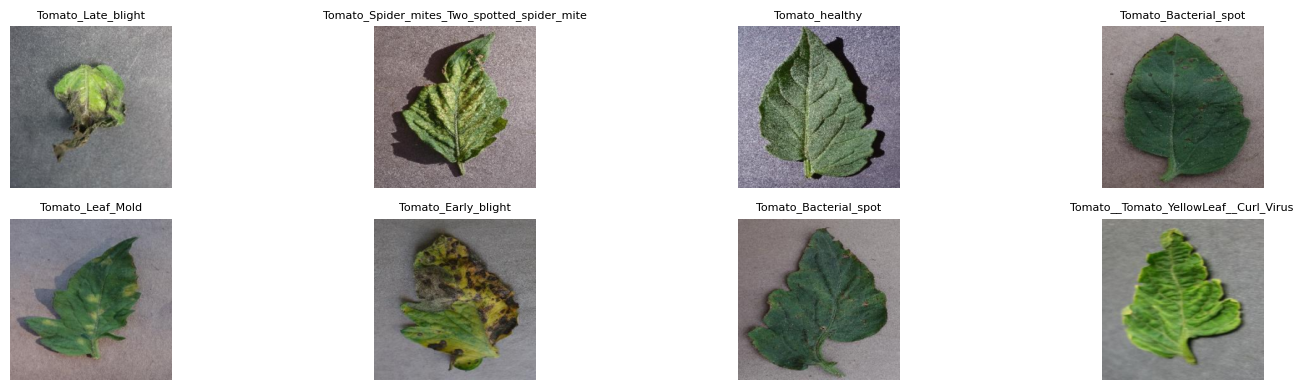

In [17]:
def show_batch(images, labels, classes, n=8):
    plt.figure(figsize=(16, 4))
    for i in range(n):
        img = images[i]
        if 'denorm' in globals():
            img = denorm(img)
        img = img.permute(1, 2, 0).numpy()  # C,H,W -> H,W,C
        img = np.clip(img, 0, 1)

        ax = plt.subplot(2, n//2, i+1)
        ax.imshow(img)
        ax.set_title(classes[labels[i].item()], fontsize=8)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

images, labels = next(iter(train_loader))
show_batch(images, labels, train_dataset.classes, n=8)


**EDA**

In [18]:


# Train distribution
train_labels = [label for _, label in train_dataset]
train_counts = Counter(train_labels)

print("Train class distribution:")
for idx, class_name in enumerate(train_dataset.classes):
    print(f"{class_name}: {train_counts[idx]}")

# Test distribution
test_labels = [label for _, label in test_dataset]
test_counts = Counter(test_labels)

print("\nTest class distribution:")
for idx, class_name in enumerate(test_dataset.classes):
    print(f"{class_name}: {test_counts[idx]}")


Train class distribution:
Tomato_Bacterial_spot: 1595
Tomato_Early_blight: 750
Tomato_Late_blight: 1431
Tomato_Leaf_Mold: 714
Tomato_Septoria_leaf_spot: 1328
Tomato_Spider_mites_Two_spotted_spider_mite: 1257
Tomato__Target_Spot: 1053
Tomato__Tomato_YellowLeaf__Curl_Virus: 2406
Tomato__Tomato_mosaic_virus: 279
Tomato_healthy: 1193

Test class distribution:
Tomato_Bacterial_spot: 532
Tomato_Early_blight: 250
Tomato_Late_blight: 478
Tomato_Leaf_Mold: 238
Tomato_Septoria_leaf_spot: 443
Tomato_Spider_mites_Two_spotted_spider_mite: 419
Tomato__Target_Spot: 351
Tomato__Tomato_YellowLeaf__Curl_Virus: 802
Tomato__Tomato_mosaic_virus: 94
Tomato_healthy: 398


Chechking Inconsistencies


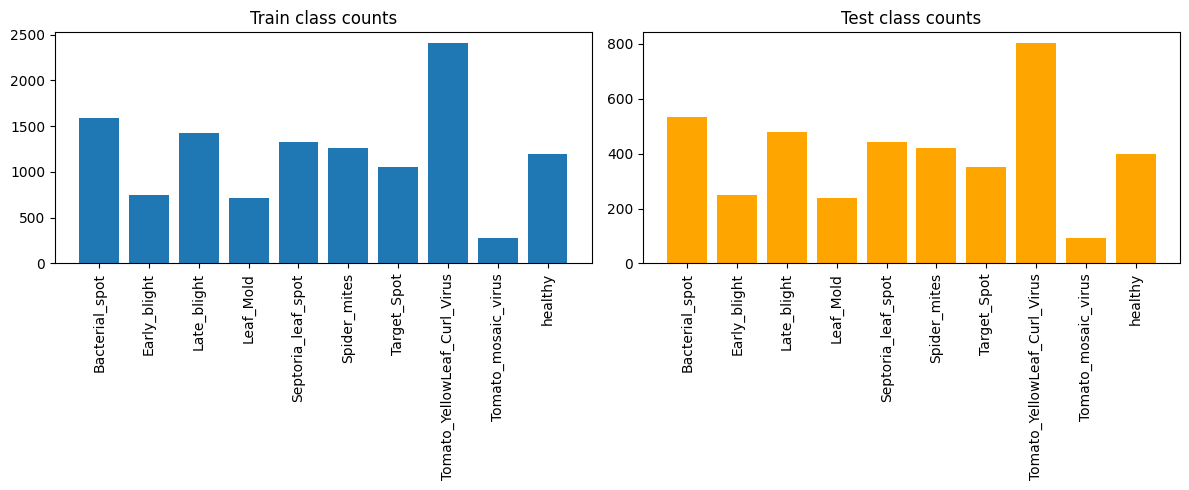

In [19]:
import matplotlib.pyplot as plt

train_counts_list = [1595, 750, 1431, 714, 1328, 1257, 1053, 2406, 279, 1193]
test_counts_list  = [532, 250, 478, 238, 443, 419, 351, 802, 94, 398]

classes = [
    "Bacterial_spot",
    "Early_blight",
    "Late_blight",
    "Leaf_Mold",
    "Septoria_leaf_spot",
    "Spider_mites",
    "Target_Spot",
    "Tomato_YellowLeaf_Curl_Virus",
    "Tomato_mosaic_virus",
    "healthy"
]

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.bar(classes, train_counts_list)
plt.xticks(rotation=90)
plt.title("Train class counts")

plt.subplot(1,2,2)
plt.bar(classes, test_counts_list, color="orange")
plt.xticks(rotation=90)
plt.title("Test class counts")

plt.tight_layout()
plt.show()


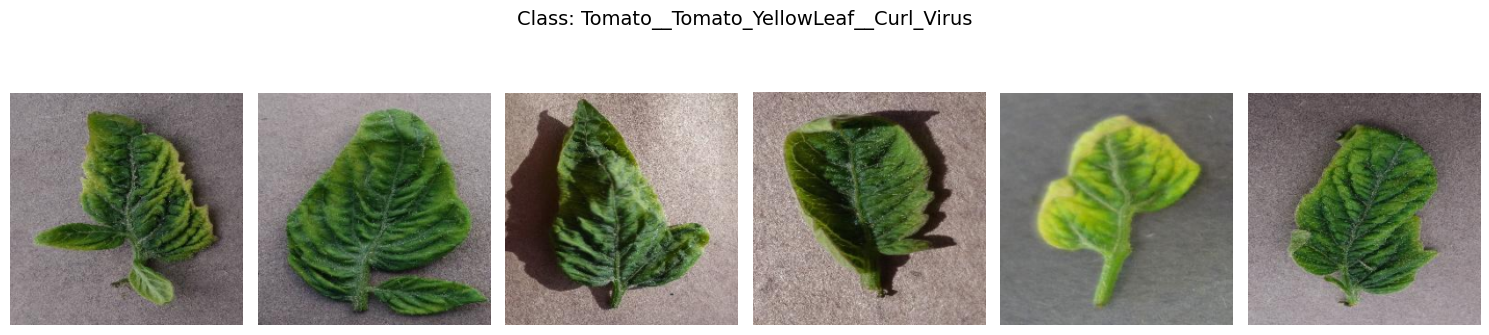

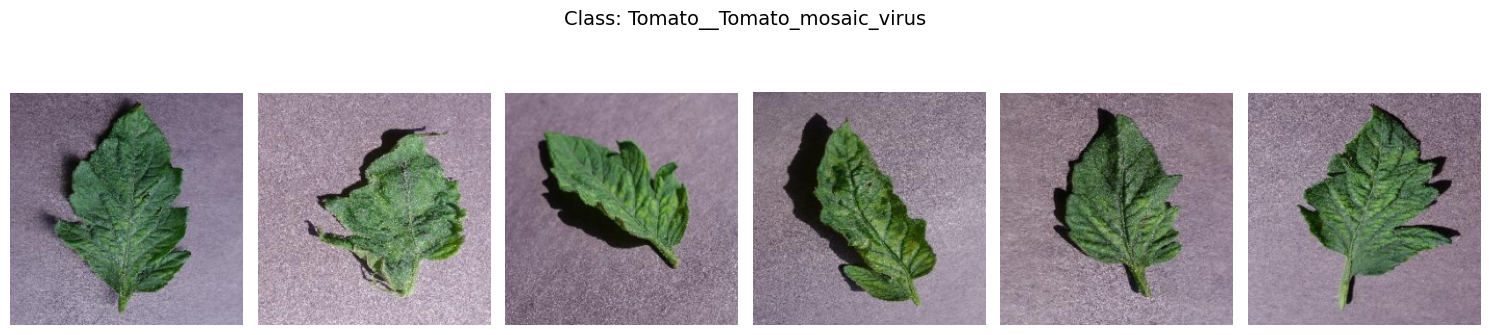

In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# ImageNet stats
mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

def denorm(img):
    return img * std + mean

def show_examples_for_class(ds, class_name, n=6):
    idx = ds.class_to_idx[class_name]
    indices = [i for i, (_, y) in enumerate(ds.samples) if y == idx]

    # Increase figure height slightly to make room for suptitle
    fig, axes = plt.subplots(1, n, figsize=(15, 3.5))

    # Clean main title for the whole row
    fig.suptitle(f"Class: {class_name}", fontsize=14, y=1.02)

    for j, img_idx in enumerate(indices[:n]):
        img, label = ds[img_idx]
        img = denorm(img)
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)

        axes[j].imshow(img)
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

# Run for your classes (using 'traindataset' variable name from your notebook)
show_examples_for_class(train_dataset, "Tomato__Tomato_YellowLeaf__Curl_Virus", n=6)
show_examples_for_class(train_dataset, "Tomato__Tomato_mosaic_virus", n=6)


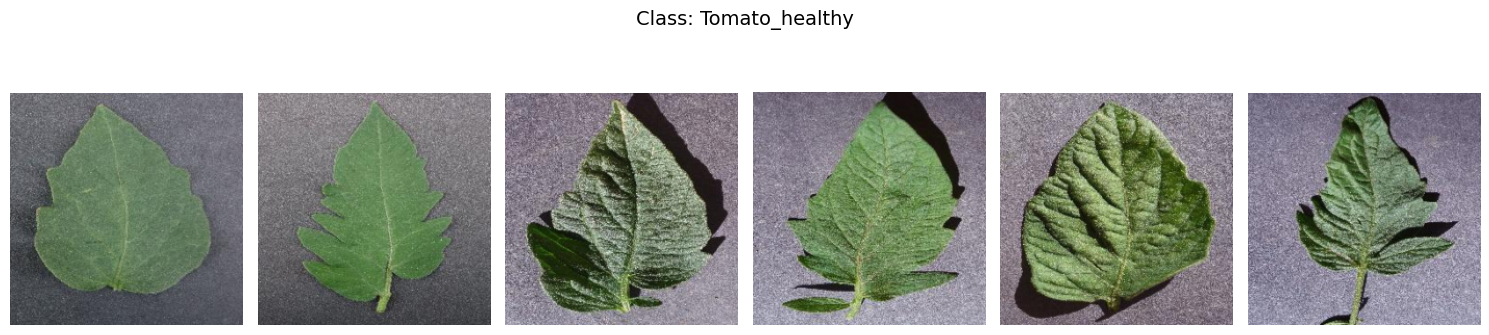

In [21]:
# Visualize Healthy Class to compare backgrounds
show_examples_for_class(train_dataset, "Tomato_healthy", n=6)


In [22]:


# 1. Define Transforms
# Training: Augmentation to handle shadows, orientation, and prevent overfitting
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),        # Standard size for most CNNs
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5), # Leaves can be upside down
    transforms.RandomRotation(30),        # Rotates ±30 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Handles lighting differences
    transforms.ToTensor(),                # Convert image to Tensor (0-1 float)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # ImageNet stats (standard practice)
                         std=[0.229, 0.224, 0.225])
])

# Testing/Validation: No augmentation, just resize and normalize
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 2. Re-create Datasets with specific transforms
# Ensure 'splitroot' variable is still defined from your previous cells
# If not, uncomment and set: splitroot = "path/to/plantdiseasedataset10classessplit"
train_dataset = datasets.ImageFolder(root=os.path.join(split_root, "train"), transform=train_transform)
test_dataset  = datasets.ImageFolder(root=os.path.join(split_root, "test"),  transform=test_transform)

# 3. Create DataLoaders
BATCH_SIZE = 32  # Good starting point for Colab GPU
NUM_WORKERS = 2  # Speed up data loading

train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,      # Shuffle training data!
                          num_workers=NUM_WORKERS)

test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,      # No need to shuffle test data
                         num_workers=NUM_WORKERS)

# 4. Final Sanity Check
print(f"✅ DataLoaders ready!")
print(f"Training batches: {len(train_loader)}")
print(f"Testing batches:  {len(test_loader)}")
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}")  # Should be [32, 3, 224, 224]


✅ DataLoaders ready!
Training batches: 376
Testing batches:  126
Batch shape: torch.Size([32, 3, 224, 224])


Analyzing Tomato_healthy:  93%|█████████▎| 11112/12006 [00:15<00:01, 728.65it/s]


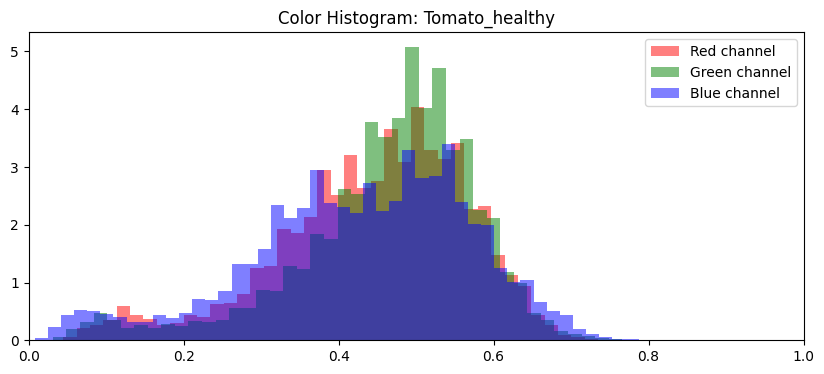

Analyzing Tomato__Tomato_YellowLeaf__Curl_Virus:  70%|███████   | 8427/12006 [00:10<00:04, 795.33it/s]


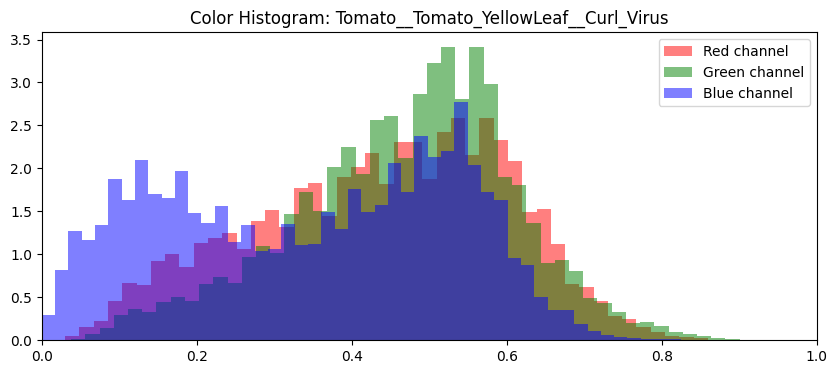

In [23]:


# 1. Define a simple 'raw' dataset for EDA (no normalization, just tensor)
# We make it small (64x64) just to speed up calculation
eda_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Use 'split_root' variable you defined earlier
eda_train_data = datasets.ImageFolder(root=os.path.join(split_root, "train"), transform=eda_transform)

# 2. Function to plot color distributions
def analyze_colors(dataset, class_filter=None):
    r_vals, g_vals, b_vals = [], [], []

    # Iterate through dataset
    # If class_filter is set (e.g., "Tomato_healthy"), only check that class
    target_idx = dataset.class_to_idx[class_filter] if class_filter else None

    # Check max 300 images to be fast
    count = 0
    for img, label in tqdm(dataset, desc=f"Analyzing {class_filter if class_filter else 'All'}"):
        if target_idx is not None and label != target_idx:
            continue

        r_vals.append(img[0].flatten().numpy())
        g_vals.append(img[1].flatten().numpy())
        b_vals.append(img[2].flatten().numpy())

        count += 1
        if count >= 300: break

    r_vals = np.concatenate(r_vals)
    g_vals = np.concatenate(g_vals)
    b_vals = np.concatenate(b_vals)

    plt.figure(figsize=(10, 4))
    plt.hist(r_vals, bins=50, color='red', alpha=0.5, label='Red channel', density=True)
    plt.hist(g_vals, bins=50, color='green', alpha=0.5, label='Green channel', density=True)
    plt.hist(b_vals, bins=50, color='blue', alpha=0.5, label='Blue channel', density=True)
    plt.title(f"Color Histogram: {class_filter if class_filter else 'Entire Dataset'}")
    plt.xlim(0, 1)
    plt.legend()
    plt.show()

# 3. Compare Healthy vs. Yellow Leaf Curl
analyze_colors(eda_train_data, "Tomato_healthy")
analyze_colors(eda_train_data, "Tomato__Tomato_YellowLeaf__Curl_Virus")


In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# 1. Load Pre-trained ResNet18
# Weights='DEFAULT' downloads the best available ImageNet weights
model = models.resnet18(weights='DEFAULT')

# 2. Modify the Final Layer (Head)
# ResNet18's original final layer is 'fc' with 1000 outputs. We need 10.
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10) # 10 classes for Tomato dataset

# 3. Move to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"Model loaded and moved to {device}")

# 4. Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
# Learning rate 0.001 is standard for fine-tuning
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 5. Simple Training Function
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

# 6. Run Training for 5 Epochs (Quick Test)
print("Starting training...")
for epoch in range(5):
    loss, acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    print(f"Epoch {epoch+1}: Loss = {loss:.4f}, Accuracy = {acc:.2f}%")

print("Training complete!")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 151MB/s]


Model loaded and moved to cuda
Starting training...
Epoch 1: Loss = 0.4816, Accuracy = 83.87%
Epoch 2: Loss = 0.2395, Accuracy = 92.25%
Epoch 3: Loss = 0.1881, Accuracy = 93.63%
Epoch 4: Loss = 0.1623, Accuracy = 94.52%
Epoch 5: Loss = 0.1468, Accuracy = 95.06%
Training complete!


🔍 Inspecting 12006 raw images in: /root/.cache/kagglehub/datasets/anamikachhabra/leaf-based-tomato-plant-disease-recognition-data/versions/2/plant_disease_dataset_10_classes_split/plant_disease_dataset_10_classes_split/train


Checking dimensions: 100%|██████████| 12006/12006 [00:01<00:00, 6097.79it/s] 



📊 --- Resolution Statistics ---
Count: 12006 images
Min Resolution: 256 x 256
Max Resolution: 256 x 256
Avg Resolution: 256.0 x 256.0


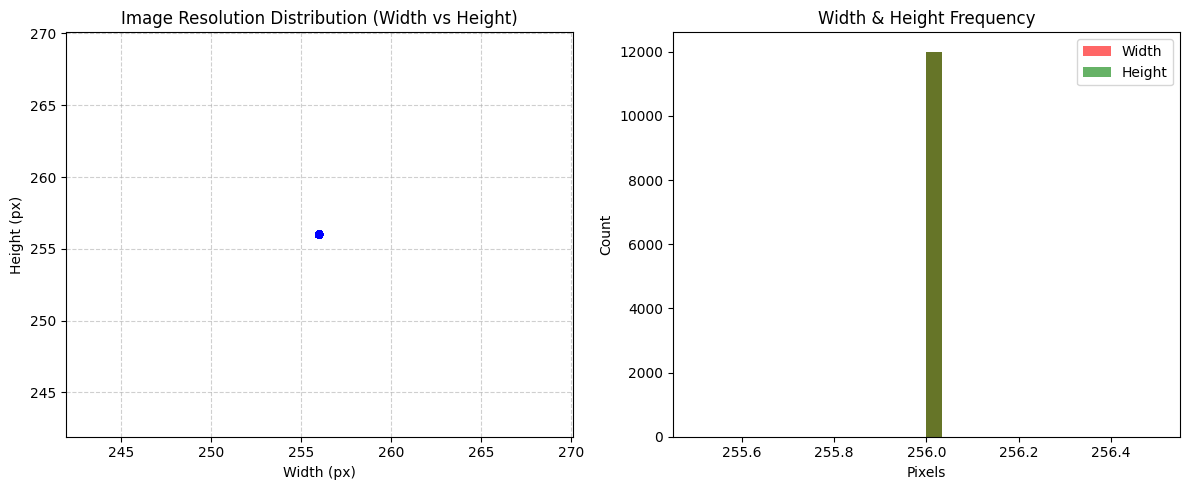

In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

def inspect_raw_resolutions(directory):
    widths = []
    heights = []

    # 1. Collect all image paths
    image_paths = []
    valid_exts = {'.jpg', '.jpeg', '.png', '.bmp'}

    for root, _, files in os.walk(directory):
        for file in files:
            if os.path.splitext(file)[1].lower() in valid_exts:
                image_paths.append(os.path.join(root, file))

    print(f"🔍 Inspecting {len(image_paths)} raw images in: {directory}")

    # 2. Get dimensions (without loading full image data for speed)
    for path in tqdm(image_paths, desc="Checking dimensions"):
        try:
            with Image.open(path) as img:
                w, h = img.size
                widths.append(w)
                heights.append(h)
        except Exception as e:
            print(f"⚠️ Could not read {path}: {e}")

    # 3. Calculate Statistics
    widths = np.array(widths)
    heights = np.array(heights)

    print(f"\n📊 --- Resolution Statistics ---")
    print(f"Count: {len(widths)} images")
    print(f"Min Resolution: {widths.min()} x {heights.min()}")
    print(f"Max Resolution: {widths.max()} x {heights.max()}")
    print(f"Avg Resolution: {widths.mean():.1f} x {heights.mean():.1f}")

    # 4. Visualization
    plt.figure(figsize=(12, 5))

    # Scatter Plot: Width vs Height
    plt.subplot(1, 2, 1)
    plt.scatter(widths, heights, alpha=0.3, c='blue', edgecolors='none')
    plt.title("Image Resolution Distribution (Width vs Height)")
    plt.xlabel("Width (px)")
    plt.ylabel("Height (px)")
    plt.grid(True, linestyle='--', alpha=0.6)

    # Histograms
    plt.subplot(1, 2, 2)
    plt.hist(widths, bins=30, alpha=0.6, color='red', label='Width')
    plt.hist(heights, bins=30, alpha=0.6, color='green', label='Height')
    plt.title("Width & Height Frequency")
    plt.xlabel("Pixels")
    plt.ylabel("Count")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Run the inspection on the training directory
# Ensure 'split_root' is defined from your previous cells
train_dir_path = os.path.join(split_root, "train")
inspect_raw_resolutions(train_dir_path)


In [26]:
import os
import shutil
from google.colab import drive

# 1. Mount Google Drive
# This will prompt you for permission to access your Drive
drive.mount('/content/drive')

# 2. Define your destination paths
drive_root = '/content/drive/MyDrive'
final_assignment_path = os.path.join(drive_root, 'assignment_final')
day1_folder_path = os.path.join(final_assignment_path, 'Files_day1')

# 3. Create the directories if they don't exist
# exist_ok=True prevents errors if you run the cell multiple times
os.makedirs(day1_folder_path, exist_ok=True)
print(f"✅ Directory ensured: {day1_folder_path}")

# 4. Identify files to copy
# We define the current working directory (usually /content in Colab)
source_dir = '/content'

# List of items to IGNORE (system files)
ignore_list = ['.config', 'drive', 'sample_data']

print("Copying files...")
for item in os.listdir(source_dir):
    # Skip hidden files and system directories
    if item.startswith('.') or item in ignore_list:
        continue

    source_item = os.path.join(source_dir, item)
    dest_item = os.path.join(day1_folder_path, item)

    # Copy files
    if os.path.isfile(source_item):
        shutil.copy2(source_item, dest_item)
        print(f"  Copied file: {item}")
    # Copy directories (recursively)
    elif os.path.isdir(source_item):
        if os.path.exists(dest_item):
            shutil.rmtree(dest_item) # Remove old version to overwrite
        shutil.copytree(source_item, dest_item)
        print(f"  Copied folder: {item}")

print("✅ All files copied successfully.")

# 5. Create a Zip file of the Day 1 folder
# The zip will be saved inside 'assignment_final'
zip_filename = os.path.join(final_assignment_path, 'Files_day1') # .zip is added automatically
shutil.make_archive(zip_filename, 'zip', day1_folder_path)

print(f"✅ Zip file created: {zip_filename}.zip")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Directory ensured: /content/drive/MyDrive/assignment_final/Files_day1
Copying files...
  Copied file: Tomato_Disease_Detection_ResNet18_Epoch5_95acc_20260201-065430.zip
  Copied file: best_model.pth
  Copied file: training_log.csv
✅ All files copied successfully.
✅ Zip file created: /content/drive/MyDrive/assignment_final/Files_day1.zip
